<a href="https://colab.research.google.com/github/kaisei3506/close_price_prediction/blob/main/close_price_prediction_by_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [75]:
!pip install japanize_matplotlib
import japanize_matplotlib

In [76]:
# 再現性の確保

import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

try:
    tf.config.experimental.enable_op_determinism()
    print("TensorFlow deterministic operations enabled.")
except AttributeError as e:
    print(f"Note: tf.config.experimental.enable_op_determinism() not available in this TF version. Using TF_DETERMINISTIC_OPS='1' might be necessary if supported. Error: {e}")


TensorFlow deterministic operations enabled.


In [77]:
df = pd.read_csv('/content/drive/MyDrive/assignment-main(new)/Trainee/time-series-prediction/my_cleaned_stock_price.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,close,open,high,low,volume,return
date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,0.1625
1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-0.0543
1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,0.0174
1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,0.0393
1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,0.0482
...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,1.550800e+08,-0.0013
2024-07-29,159.7,158.7,160.2,158.4,1.262800e+08,0.0114
2024-07-30,158.7,158.8,159.2,158.0,1.381400e+08,-0.0063


In [78]:
import holidays

def compute_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(span=window, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(span=window, adjust=False).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def engineer(df_old):

  df_new = df_old.copy()

  df_new['sin_dayofyear'] = np.sin(2 * np.pi * df_new.index.dayofyear / 365)
  df_new['cos_dayofyear'] = np.cos(2 * np.pi * df_new.index.dayofyear / 365)
  df_new['sin_dayofmonth'] = np.sin(2 * np.pi * df_new.index.day / 30)
  df_new['cos_dayofmonth'] = np.cos(2 * np.pi * df_new.index.day / 30)
  '''
  df_new['sin_dayofweek'] = np.sin(2 * np.pi * df_new.index.dayofweek / 7)
  df_new['cos_dayofweek'] = np.cos(2 * np.pi * df_new.index.dayofweek / 7)

  # 日本の休日
  jp_holidays = holidays.Japan()
  df_new['holiday'] = df_new.index.map(lambda x: 1 if x in jp_holidays else 0)
  '''
  # 移動平均、相対力指数
  sma_list = [5, 10, 20]
  for i in sma_list:
    df_new[f'sma_{i}'] = df_new['close'].rolling(window=i).mean()
    df_new[f'ema_{i}'] = df_new['close'].ewm(span=i, adjust=False).mean()
    df_new[f'rsi_{i}'] = compute_rsi(df_new, window=i)

  # 標準偏差
  for i in sma_list:
    df_new[f'std_{i}'] = df_new['close'].rolling(window=i).std()

  # 急激な上昇をとらえる
  for i in range(len(sma_list)):
    for j in range(i+1, len(sma_list)):

      df_new[f'sma_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'sma_{sma_list[i]}'] / df_new[f'sma_{sma_list[j]}']

      # ゴールデンクロス
      df_new[f'gc_{sma_list[i]}vs{sma_list[j]}'] = (df_new[f'sma_{sma_list[i]}'].shift(1) < df_new[f'sma_{sma_list[j]}'].shift(1)) & (df_new[f'sma_{sma_list[i]}'] >= df_new[f'sma_{sma_list[j]}'])
      # デッドクロス
      df_new[f'dc_{sma_list[i]}vs{sma_list[j]}'] = (df_new[f'sma_{sma_list[i]}'].shift(1) > df_new[f'sma_{sma_list[j]}'].shift(1)) & (df_new[f'sma_{sma_list[i]}'] <= df_new[f'sma_{sma_list[j]}'])
      '''
      # MACD
      df_new[f'macd_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'ema_{sma_list[i]}'] - df_new[f'ema_{sma_list[j]}']
      df_new[f'macd_signal_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'macd_{sma_list[i]}vs{sma_list[j]}'].ewm(span=9, adjust=False).mean()
      '''

  # ADX
  epsilon = 1e-6
  df_new['+DM'] = df_new['high'] - df_new['high'].shift(1)
  df_new['-DM'] = df_new['low'].shift(1) - df_new['low']
  df_new['TR'] = np.maximum.reduce([
    df_new['high'] - df_new['low'],
    abs(df_new['high'] - df_new['close'].shift(1)),
    abs(df_new['low'] - df_new['close'].shift(1))
    ])
  df_new['+DI'] = df_new['+DM'].rolling(window=14).sum() / (df_new['TR'].rolling(window=14).sum() + epsilon) * 100
  df_new['-DI'] = df_new['-DM'].rolling(window=14).sum() / (df_new['TR'].rolling(window=14).sum() + epsilon) * 100
  df_new['DX'] = abs((df_new['+DI'] - df_new['-DI']) / (df_new['+DI'] + df_new['-DI'] + epsilon)) * 100
  df_new['ADX'] = df_new['DX'].rolling(window=14).mean()

  # ストキャスティクス
  df_new['%K'] = (df_new['close'] - df_new['low'].rolling(window=14).min()) / (df_new['high'].rolling(window=14).max() - df_new['low'].rolling(window=14).min()) * 100
  df_new['%D'] = df_new['%K'].rolling(window=3).mean()



  df_new = df_new.drop(['volume', '+DI', '-DI'], axis=1)

  df_new = df_new.dropna()


  return df_new

engineered_df = engineer(df)
engineered_df

,close,open,high,low,return,sin_dayofyear,cos_dayofyear,sin_dayofmonth,cos_dayofmonth,sma_5,...,sma_10vs20,gc_10vs20,dc_10vs20,+DM,-DM,TR,DX,ADX,%K,%D
date,,,,,,,,,,,,,,,,,,,,,
1987-03-23,260.8,263.7,267.6,260.8,0.0038,0.987349,0.158559,-9.945219e-01,0.104528,267.26,...,1.008292,False,False,5.8,-5.9,7.8,2.450001e+02,5.781730e+08,14.676617,12.637943
1987-03-24,256.9,264.7,264.7,256.9,-0.0150,0.989932,0.141540,-9.510565e-01,0.309017,263.14,...,1.003613,False,False,-2.9,3.9,7.8,1.420000e+03,5.781730e+08,5.235602,10.700425
1987-03-25,254.9,255.9,256.9,252.9,-0.0078,0.992222,0.124479,-8.660254e-01,0.500000,259.22,...,0.993846,False,True,-7.8,4.0,4.0,7.321840e+02,5.781729e+08,4.975124,8.295781
1987-03-26,262.7,258.8,264.7,255.9,0.0306,0.994218,0.107381,-7.431448e-01,0.669131,259.02,...,0.983061,False,False,7.8,-3.0,9.8,1.858621e+03,5.781721e+08,26.997245,12.402657
1987-03-27,274.5,267.6,284.3,263.7,0.0449,0.995919,0.090252,-5.877853e-01,0.809017,261.96,...,0.975768,False,False,19.6,-7.8,21.6,1.609375e+02,5.781706e+08,59.504132,30.492167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,-0.0013,-0.425000,-0.905193,-7.431448e-01,0.669131,159.02,...,1.008145,False,False,0.6,-1.1,1.7,2.100004e+03,8.685501e+08,56.818182,59.848485
2024-07-29,159.7,158.7,160.2,158.4,0.0114,-0.471160,-0.882048,-2.079117e-01,0.978148,158.98,...,1.006259,False,False,0.6,-0.5,2.3,1.733334e+03,4.649221e+08,75.609756,63.839616
2024-07-30,158.7,158.8,159.2,158.0,-0.0063,-0.486273,-0.873807,-1.133108e-15,1.000000,158.58,...,1.006412,False,False,-1.0,0.4,1.7,2.913044e+02,4.649221e+08,50.000000,60.809313


In [79]:
train_valid = engineered_df['2019-01-01':'2023-12-31']

train = train_valid[:'2022-11-30']
enbargo_train_valid = train_valid['2022-12-01':'2022-12-31']
valid = train_valid['2023-01-01':'2023-07-31']
enbargo_valid_test = engineered_df['2023-08-01':'2024-12-31']
test = engineered_df['2024-01-01':'2024-07-31']

In [80]:
sequence_length = 22
predict_length = 1

def create_dataset(data, sequence_length, predict_length):
  X, y = [], []
  for i in range(len(data) - sequence_length - predict_length + 1):
    X.append(data[i:i+sequence_length, :])
    y.append(data[i+sequence_length:i+sequence_length+predict_length, 0])
  return np.array(X), np.array(y)

X_train, y_train = create_dataset(train.values, sequence_length, predict_length)
X_valid, y_valid = create_dataset(valid.values, sequence_length, predict_length)
X_test, y_test = create_dataset(test.values, sequence_length, predict_length)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(928, 22, 37)
(928, 1, 1)
(120, 22, 37)
(120, 1, 1)


In [81]:
from sklearn.preprocessing import StandardScaler

# 特徴量（X）のスケーリング
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid_scaled = scaler_X.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 目的変数（y）のスケーリング
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, y_valid.shape[-1])).reshape(y_valid.shape)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers as optim
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

In [83]:
# LSTM

lstm_model = Sequential()

lstm_model.add(LSTM(units=128,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=64,
                    return_sequences=True,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=32,
                    return_sequences=False,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(predict_length,
                     kernel_regularizer=regularizers.l2(0.001)
                     )
)


optimizer = optim.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')
lstm_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 22, 128)        │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 22, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,849 (573.63 KB)

 Trainable params: 146,849 (573.63 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)
lstm_model.fit(X_train_scaled, y_train_scaled,
               epochs=1000,
               batch_size=64,
               validation_data=(X_valid_scaled, y_valid_scaled),
               shuffle=False,
               callbacks=[es])

# 検証データの損失が最も小さかったエポックを取得
best_epoch = np.argmin(lstm_model.history.history['val_loss']) + 1
print(f"検証データの損失が最も小さかったエポック: {best_epoch}")
# そのエポックの学習損失と検証損失を取得
best_train_loss = lstm_model.history.history['loss'][best_epoch - 1]
best_val_loss = lstm_model.history.history['val_loss'][best_epoch - 1]
print(f"エポック {best_epoch}での学習損失: {best_train_loss}")
print(f"エポック {best_epoch}での検証損失: {best_val_loss}")

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - loss: 0.7621 - val_loss: 0.7103
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - loss: 0.7191 - val_loss: 1.1636
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 0.6097 - val_loss: 1.7738
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.5320 - val_loss: 0.6556
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.4988 - val_loss: 0.5720
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.4689 - val_loss: 0.5004
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.4555 - val_loss: 0.5164
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.4471 - val_loss: 0.5826
Epoch 9/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.4611 - val_loss: 0.4568
Epoch 10/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4719 - val_loss: 0.6444
Epoch 11/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4040 - val_loss: 0.4614
Epoch 12/1000
15/15 ━━━━━━━━━━━━━━

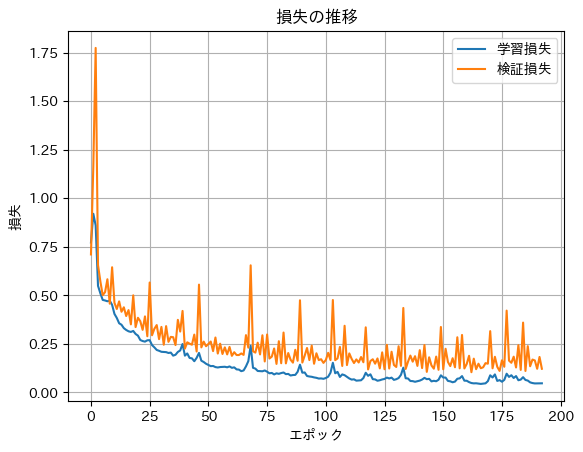

In [85]:
# 損失関数の推移
plt.plot(lstm_model.history.history['loss'], label='学習損失')
plt.plot(lstm_model.history.history['val_loss'], label='検証損失')
plt.title('損失の推移')
plt.xlabel('エポック')
plt.ylabel('損失')
plt.legend()
plt.grid()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━

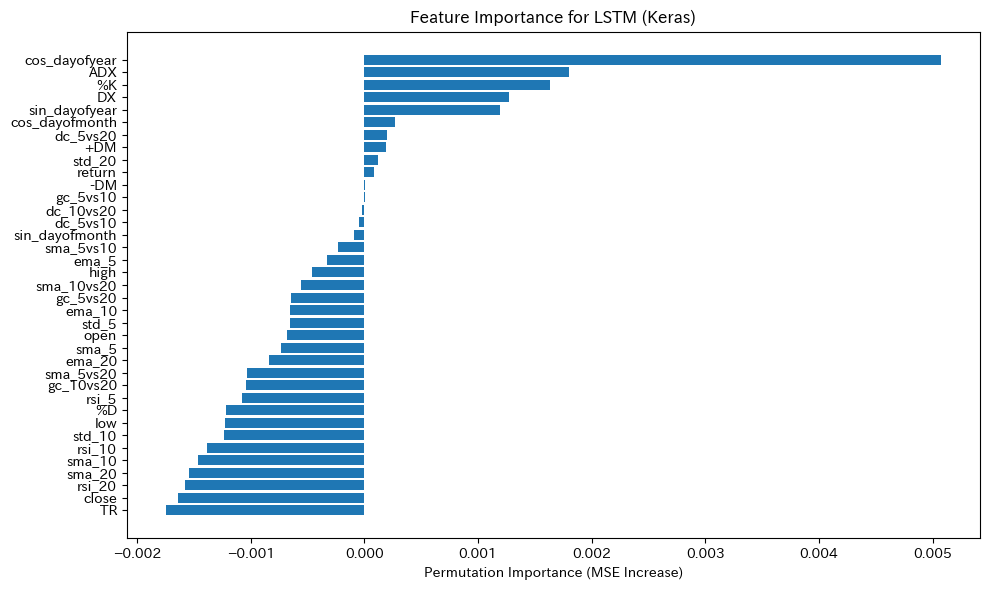

           Feature  Importance
6    cos_dayofyear    0.005074
34             ADX    0.001803
35              %K    0.001630
33              DX    0.001271
5    sin_dayofyear    0.001196
8   cos_dayofmonth    0.000265
26        dc_5vs20    0.000199
30             +DM    0.000189
20          std_20    0.000120
4           return    0.000081
31             -DM    0.000008
22        gc_5vs10    0.000003
29       dc_10vs20   -0.000022
23        dc_5vs10   -0.000048
7   sin_dayofmonth   -0.000092
21       sma_5vs10   -0.000237
10           ema_5   -0.000328
2             high   -0.000457
27      sma_10vs20   -0.000560
25        gc_5vs20   -0.000649
13          ema_10   -0.000652
18           std_5   -0.000656
1             open   -0.000680
9            sma_5   -0.000737
16          ema_20   -0.000843
24       sma_5vs20   -0.001031
28       gc_10vs20   -0.001046
11           rsi_5   -0.001079
36              %D   -0.001220
3              low   -0.001224
19          std_10   -0.001238
14      

In [86]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 検証データ（X_valid_scaled）は (samples, timesteps, features) の形
X_valid_copy = X_valid_scaled.copy()
baseline_preds = lstm_model.predict(X_valid_scaled).ravel()
baseline_score = mean_squared_error(y_valid_scaled.ravel(), baseline_preds)

# 特徴量数
n_features = X_valid_scaled.shape[2]
feature_names = engineered_df.columns

# 順列重要度を格納
importances = []

# 各特徴量について
for i in range(n_features):
    # コピーを作成
    X_permuted = X_valid_copy.copy()

    # 各time stepでその特徴をシャッフル
    for t in range(X_valid_scaled.shape[1]):  # timesteps
        np.random.seed(42)
        np.random.shuffle(X_permuted[:, t, i])

    # 予測してスコア計算
    permuted_preds = lstm_model.predict(X_permuted).ravel()
    permuted_score = mean_squared_error(y_valid_scaled.ravel(), permuted_preds)

    # スコアの悪化分を重要度とする
    importance = permuted_score - baseline_score
    importances.append(importance)

# 結果をDataFrameにまとめて可視化
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance (MSE Increase)')
plt.title('Feature Importance for LSTM (Keras)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 表としても表示
print(importance_df)


In [87]:
# 重要度が0以下の特徴量を取得
cols = importance_df[importance_df['Importance'] <= 0]['Feature']
cols = cols.values
cols

array(['dc_10vs20', 'dc_5vs10', 'sin_dayofmonth', 'sma_5vs10', 'ema_5',
       'high', 'sma_10vs20', 'gc_5vs20', 'ema_10', 'std_5', 'open',
       'sma_5', 'ema_20', 'sma_5vs20', 'gc_10vs20', 'rsi_5', '%D', 'low',
       'std_10', 'rsi_10', 'sma_10', 'sma_20', 'rsi_20', 'close', 'TR'],
      dtype=object)

In [88]:
'''
from sklearn.metrics import mean_squared_error

y_test_pred_scaled = lstm_model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_pred = y_test_pred.flatten()
y_test = y_test.flatten()

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Test RMSE: {test_rmse}")
'''

'\nfrom sklearn.metrics import mean_squared_error\n\ny_test_pred_scaled = lstm_model.predict(X_test_scaled)\ny_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)\ny_test_pred = y_test_pred.flatten()\ny_test = y_test.flatten()\n\ntest_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))\n\nprint(f"Test RMSE: {test_rmse}")\n'

In [89]:
'''
plt.figure(figsize=(12,8))
plt.plot(test[sequence_length:].index, y_test, label='実測値')
plt.plot(test[sequence_length:].index, y_test_pred, label='予測値')
plt.title('終値の予測', fontsize=25)
plt.xlabel('日付', fontsize=20)
plt.ylabel('価格(円)', fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()
'''

"\nplt.figure(figsize=(12,8))\nplt.plot(test[sequence_length:].index, y_test, label='実測値')\nplt.plot(test[sequence_length:].index, y_test_pred, label='予測値')\nplt.title('終値の予測', fontsize=25)\nplt.xlabel('日付', fontsize=20)\nplt.ylabel('価格(円)', fontsize=20)\nplt.legend(fontsize=20)\nplt.grid()\nplt.show()\n"

In [90]:
'''
plt.figure(figsize=(16,8))
plt.plot(test.index, test['close'].values, label='Actual')
plt.plot(test[sequence_length:].index, y_test_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
'''

"\nplt.figure(figsize=(16,8))\nplt.plot(test.index, test['close'].values, label='Actual')\nplt.plot(test[sequence_length:].index, y_test_pred, label='Predicted')\nplt.title('Stock Price Prediction')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.legend()\nplt.grid()\nplt.show()\n"